<a href="https://colab.research.google.com/github/djbyrne/adventures_in_cuda/blob/main/blur_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook outlines how to make a 2D kernel for bluring an image based on the content of [Programming Massively Parallel Processors](https://www.amazon.co.uk/Programming-Massively-Parallel-Processors-Hands/dp/0323912311/ref=pd_lpo_sccl_1/259-1996709-6557616?pd_rd_w=X5SBH&content-id=amzn1.sym.448aab69-6fff-42b9-9d7a-f6325052a6f6&pf_rd_p=448aab69-6fff-42b9-9d7a-f6325052a6f6&pf_rd_r=X9B0ZWKMXF71VYP51C4G&pd_rd_wg=ZRYEe&pd_rd_r=09a8891c-4796-463c-a030-821208a1720a&pd_rd_i=0323912311&psc=1). To blur an image, we go through each pixel and replace it with a weighted sum of its surrounding neighbours in an N x N grid. The size of N determines the strength of the blur effect. For simplicity, we will just be taking the average of this patch, giving all neighbours equal weighting.

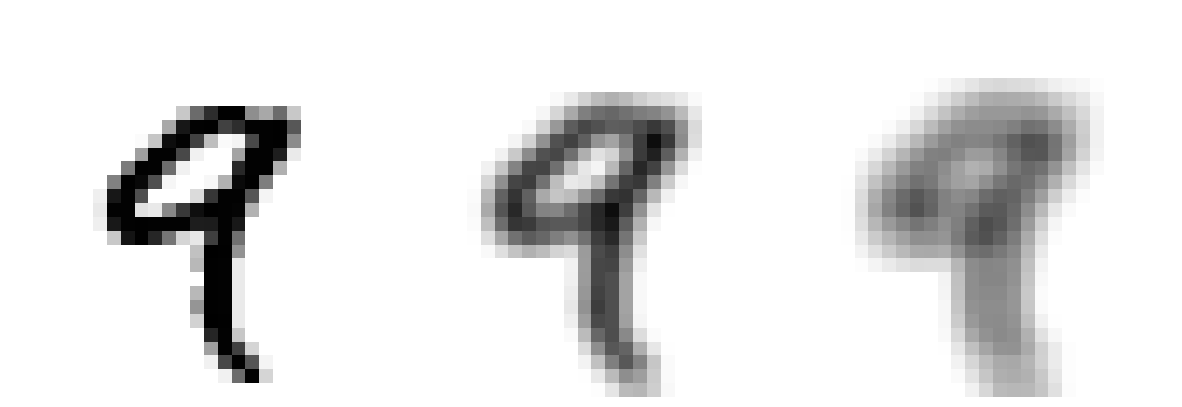

## Resources
- [Getting Started With CUDA For Python Programmers](https://www.youtube.com/watch?v=nOxKexn3iBo)
- [PMPP Chapter 3 (Unofficial Repo)](https://github.com/R100001/Programming-Massively-Parallel-Processors)

# Setup

For simplicity, we will be using simple images from the MNIST dataset that only
have 1 channel.

In [88]:
import torch, os, math, gzip, pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from urllib.request import urlretrieve
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [89]:
def show_images(images, figsize=(4,3), **kwargs):
    """
    Takes a list of images and displays them in a horizontal line.

    Parameters:
    images: List of 2D numpy arrays
    """
    # Concatenate images along width
    combined_image = np.concatenate(images, axis=1)

    # Display the concatenated image
    plt.figure(figsize=figsize)
    plt.imshow(combined_image, **kwargs)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

In [90]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [91]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [92]:
# reshape to single images
# scale pixels to be from 0-255
# cast from float32 to uint8 so it can be used by CUDA
# imgs = np.multiply(x_train.reshape(-1, 28, 28), 255).to(torch.uint8)
imgs = x_train.reshape(-1, 28, 28)
imgs.shape, imgs.type()

(torch.Size([50000, 28, 28]), 'torch.FloatTensor')

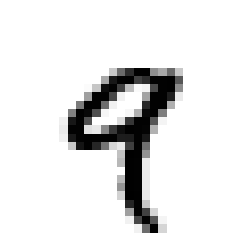

In [93]:
img = imgs[4]
show_images([img], cmap='gray_r')

# Python Blur

In [94]:
from types import SimpleNamespace as ns

In [95]:
def blk_kernel2d(f, blocks, threads, *args):
    """Emulates the behaviour of running a 2D kernel, splitting work across
    2 dimensional Blocks, followed by 2 dimensional Threads in each Block
    """
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x):
                    f(ns(x=i0,y=i1), ns(x=j0,y=j1), threads, *args)

In [96]:
def blur_bk(blockidx, threadidx, blockdim, x, output, h, w, blur_size=1):
    """Takes in the current pixel 'x' from the flattened image and finds the
    average value of surrounding neighbours according to the 'blur_size'. The
    average of this patch is then set to the output image at the position
    of the current pixel.
    """

    # get our current row and col in the CUDA block
    row = blockidx.y*blockdim.y + threadidx.y
    col  = blockidx.x*blockdim.x + threadidx.x

    # check that we are actually in bounds of our block
    if (row < h and col < w):
        pix_val = 0
        pix_count = 0

        # get the average of our surrounding pixels
        for blur_row in range(-blur_size, blur_size + 1):
            for blur_col in range(-blur_size, blur_size + 1):

                cur_row = blur_row + row
                cur_col = blur_col + col

                if cur_row > -1 and cur_row < h and cur_col > -1 and cur_col < w:

                    pix_val += x[cur_row * w + cur_col]
                    pix_count += 1

        # update the output image with the blurred value at this position
        output[row * w + col] = float(pix_val) / pix_count


    return output

In [97]:
def blur_img(x, blur_size=1):
    h,w = x.shape
    n = h*w

    # need to flatten array as this is expected by CUDA C for flat memory
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)

    # define the threads per block as well as how many blocks we need
    tpb = ns(x=13,y=13)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))

    # run our kernel across all blocks
    blk_kernel2d(blur_bk, blocks, tpb, x, res, h, w, blur_size)
    return res.view(h,w)

In [98]:
%%timeit
img_b1 = blur_img(img, 1)

119 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [99]:
img_b2 = blur_img(img, 2)

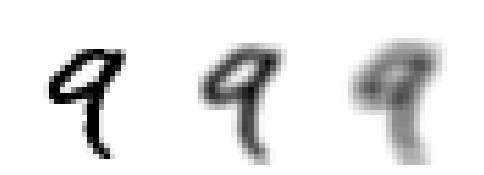

In [102]:
show_images([img, img_b1, img_b2], figsize=(6, 6), cmap='gray_r')

# CUDA Blur

Now that we understand what we want to implement, we can write the CUDA kernel.


In [81]:
# if you get an error, stop right away
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [82]:
# ninja: pytorch C compiler
# wurlitzer: lets us print from cuda into notebook
%pip install -q wurlitzer ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.6 MB/s eta 0:00:00


In [83]:
%load_ext wurlitzer

In [84]:
# compile cuda behind the scenes

def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [85]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

## Convert Python To CUDA

Following the sage advice of Jeremy Howard, we can pretty easily learn how to convert our python code to C with the help of ChatGPT. I have adopted the same prompt that Jeremy uses from his talk listed at the start of this notebook.

### Prompt
Convert this to the equivalent C code using the same names,  formatting, etc. where possible.

```python

# Put your python code here

```

This then gave me the following C code.

```c
__global__
void blurKernel(unsigned char *in, unsigned char *out, int width, int height, int blur_size)
{
    int Col = threadIdx.x + blockIdx.x * blockDim.x;
    int Row = threadIdx.y + blockIdx.y * blockDim.y;
    if (Col < width && Row < height) {

        int pixVal = 0;
        int pixels = 0;

        // Get the average of the surrounding blur_size x blur_size box
        for (int blurRow = -blur_size; blurRow < blur_size + 1; blurRow++) {
            for (int blurCol = -blur_size; blurCol < blur_size + 1; blurCol++) {
                int curRow = Row + blurRow;
                int curCol = Col + blurCol;

                // If the pixel is within the image, add its value to the sum
                if(curRow > -1 && curRow < height && curCol > -1 && curCol < width) {
                    pixVal += in[curRow*width + curCol];
                    pixels++; // Keep track of the number of pixels in the avg
                }
            }
        }
        // Write our new pixel value out
        out[Row*width + Col] = (unsigned char)(pixVal / pixels);
    }
}
```


In [86]:
cuda_src = cuda_begin + r'''
__global__
void blurKernel(unsigned char *in, unsigned char *out, int width, int height, int blur_size)
{
    int Col = threadIdx.x + blockIdx.x * blockDim.x;
    int Row = threadIdx.y + blockIdx.y * blockDim.y;
    if (Col < width && Row < height) {

        int pixVal = 0;
        int pixels = 0;

        // Get the average of the surrounding blur_size x blur_size box
        for (int blurRow = -blur_size; blurRow < blur_size + 1; blurRow++) {
            for (int blurCol = -blur_size; blurCol < blur_size + 1; blurCol++) {
                int curRow = Row + blurRow;
                int curCol = Col + blurCol;

                // If the pixel is within the image, add its value to the sum
                if(curRow > -1 && curRow < height && curCol > -1 && curCol < width) {
                    pixVal += in[curRow*width + curCol];
                    pixels++; // Keep track of the number of pixels in the avg
                }
            }
        }
        // Write our new pixel value out
        out[Row*width + Col] = (unsigned char)(pixVal / pixels);
    }
}

torch::Tensor blur(torch::Tensor x, int b) {
    CHECK_INPUT(x);
    int h = x.size(0);
    int w = x.size(1);
    auto output = torch::zeros({h, w}, x.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    blurKernel<<<blocks, tpb>>>(
        x.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), h, w, b);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [ ]:
cpp_src = "torch::Tensor blur(torch::Tensor x);"

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['blur'])

In [ ]:
dir(module)

In [ ]:
img_c = np.multiply(img, 255).to(torch.uint8)
img_c = img_c.contiguous().cuda()

In [ ]:
%%timeit
img_bc1 = module.blur(img_c, 1)

In [ ]:
img_bc2 = module.blur(img_c, 2)

In [ ]:
show_images([img_c, img_bc1, img_bc2], cmap='gray_r')